In [1]:
from skimage.measure import regionprops
from skimage.transform import resize
from skimage.segmentation import slic,mark_boundaries
from collections import Counter
import pylab as plt
import numpy as np
import os
import sys
from matplotlib.colors import ListedColormap

cMap = ListedColormap(['pink','c','lightgrey','saddlebrown','g','r','purple','royalblue','k','white','gold'])

import sys
sys.path.append('..')
from Utils.fig2img import fig2img


## CNN_superpixel functions

In [21]:
def CNN_Superpixels(im,label_tissue):
    """
    label_tissue (np.array) is feature map of the tissue level results
    """
    segments_slic = slic(im[:,:,:3], n_segments=1000, compactness=10, sigma=1)
    regions = regionprops(segments_slic)
    
    if  len(label_tissue.shape) == 2:
        #mask2 = resize(label_image,segments_slic.shape)
        mask2 = np.array(resize(np.array(label_tissue,dtype=np.int),im.shape[:2],preserve_range=True),dtype=np.int)
        mask3 = np.zeros_like(mask2)
        
        for i in range(len(regions)):
            region = regions[i]
            a,b,c,d =region.bbox

            list_of_integers = mask2[a:c,b:d][region.filled_image].flatten()
            cnt = Counter(list_of_integers)
            tlabel=cnt.most_common(1)[0][0]
            mask3[a:c,b:d][region.filled_image] = tlabel
    elif len(label_tissue.shape) == 3:
        mask2 = np.array(resize(np.array(label_tissue),im.shape[:2],preserve_range=True))
        mask3 = np.zeros_like(mask2)
        
        for i in range(len(regions)):
            region = regions[i]
            a,b,c,d =region.bbox

            list_of_integers = mask2[a:c,b:d][region.filled_image].argmax(1).flatten()
            cnt = Counter(list_of_integers)
            tlabel=cnt.most_common(1)[0][0]
            mask3[a:c,b:d][region.filled_image] = tlabel
    else:
        raise Exception("input features dimension incompatible")
    return mask3

## Load large patch function

In [3]:
import torch
import numpy as np
import pylab as plt

def process_large_image(model,input_patch,step = 28,out_scale =4,num_classes= 11,patch_size = 448,show=False,cuda_size=None):
    """
    step = 28   #sliding window step size
    out_scale =4   # the output shape of the network
    num_classes= 11   # the number of classes 
    patch_size = 448     # the patch size of the 
    """
    if input_patch.max()>2:
        test_img = input_patch/255.0
    else:
        test_img = input_patch
    tt = torch.from_numpy(((test_img[:,:,(2,1,0)]-np.array([0.485, 0.456, 0.406]))/ np.array([0.229, 0.224, 0.225])).transpose(2,0,1)).float()

    ta =tt.unfold(2,patch_size,step)
    #print(ta.size())
    tb = ta.unfold(1,patch_size,step)
    #print(tb.size())
    tc = tb.permute((1,2,0,3,4))
    #print(tc.shape)
    td = tc.reshape(-1,3,patch_size,patch_size)
    #print(td.shape)
    nx = len(range(0,test_img.shape[0]-patch_size+1,step))
    ny = len(range(0,test_img.shape[1]-patch_size+1,step))
    
    final_tensor = td
    final_result2 = []
    if cuda_size==None:
        for i in range(0,nx):
            test_tensor = final_tensor[i*ny:i*ny+ny]
            out = model(test_tensor.cuda())
            softmax = torch.nn.Softmax2d()
            out2 = softmax(out)
            final_result2.append(out2.detach().cpu().numpy())
            torch.cuda.empty_cache() 
        t = np.array(final_result2).transpose(0,3,1,4,2).reshape(nx*out_scale,ny*out_scale,num_classes)
        torch.cuda.empty_cache()
    else:
        for i in range(0,nx*ny,cuda_size):
            test_tensor = final_tensor[i:i+cuda_size]
            out = model(test_tensor.cuda())
            softmax = torch.nn.Softmax2d()
            out2 = softmax(out)
            if out2.size(0)!=cuda_size:
                tout2 = np.zeros((cuda_size,out2.size(1),out2.size(2),out2.size(3)))
                tout2[:out2.size(0)] = out2.detach().cpu().numpy()
                final_result2.append(tout2)
            else:
                final_result2.append(out2.detach().cpu().numpy())
            torch.cuda.empty_cache()
            
        tt = np.array(final_result2)
        s = tt.shape
        tt = tt.reshape(-1,s[2],s[3],s[4])[:nx*ny].reshape(nx,ny,s[2],s[3],s[4])
        t = tt.transpose(0,3,1,4,2).reshape(nx*out_scale,ny*out_scale,num_classes)
    
    if show:
        plt.subplot(1,2,1)
        plt.imshow(test_img)
        plt.subplot(1,2,2)
        plt.imshow(np.argmax(t[:,:,:],2))
    return t


## Load trained models

In [29]:
sys.path.append('../')
from Model.PatchCNN import PatchCNN

device = torch.device("cuda:0")
num_layers = [3,4,6,3]  # res34
#num_layers = [2,2,2,2] # res18
dropout_rate = 0
#dilation = 2
model_448 = PatchCNN(layers=num_layers,dropout_rate=dropout_rate)
state_dict = torch.load('/mnt/DATA_CRLM/Patches/Checkpoints/PatchCNN/PatchCNN_448_res34/PatchCNN_best.pth')
#state_dict = torch.load('/mnt/DATA_CRLM/Patches/Checkpoints/PatchCNN/PatchCNN_448_res18/PatchCNN_best.pth')
new_state_dict = {}
for key in model.state_dict():
    new_state_dict[key] = state_dict['module.'+key].double()
model_448.load_state_dict(new_state_dict)
#model_448.eval()
#model_448.to(device)

model_224 = PatchCNN(layers=[3,4,6,3],dropout_rate=0)
state_dict =torch.load(os.path.expanduser('~')+'/DATA_CRLM/Patches/Checkpoints/PatchCNN/PatchCNN_224_res34/PatchCNN_best.pth')
new_state_dict = {}
for key in model.state_dict():
    new_state_dict[key] = state_dict['module.'+key].double()
model_224.load_state_dict(new_state_dict)

In [5]:
eval_path = '/home/zyx31/DATA_CRLM/Patches/Patches_Eval/Samples/'
findex = 0
flist = os.listdir(eval_path)
flist.sort()

(278, 278, 11)
(264, 264, 11)


/home/zyx31/miniconda3/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:156: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_z = grid_z[slices]
/home/zyx31/miniconda3/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:157: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_y = grid_y[slices]
/home/zyx31/miniconda3/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq

(4096, 4096, 11)
(4096, 4096, 11)
(278, 278, 11)
(264, 264, 11)
(4096, 4096, 11)
(4096, 4096, 11)
(278, 278, 11)
(264, 264, 11)
(4096, 4096, 11)
(4096, 4096, 11)
(278, 278, 11)
(264, 264, 11)
(4096, 4096, 11)
(4096, 4096, 11)


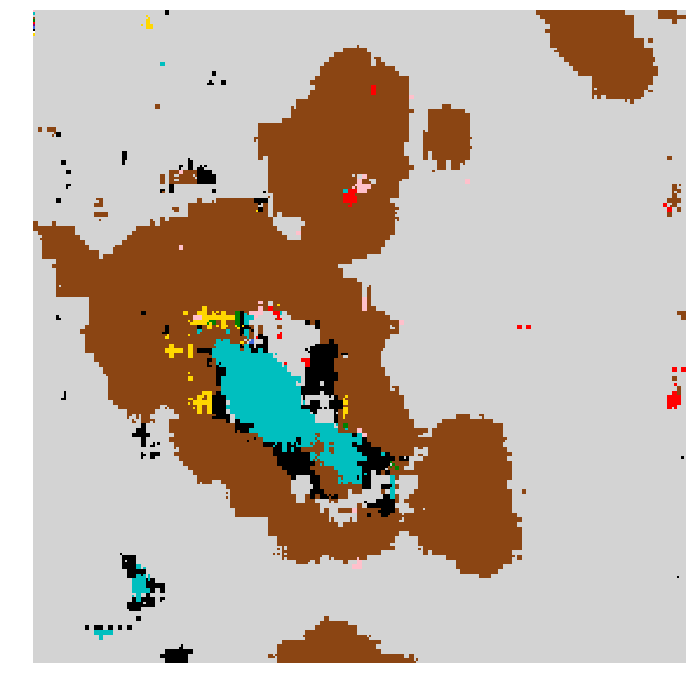

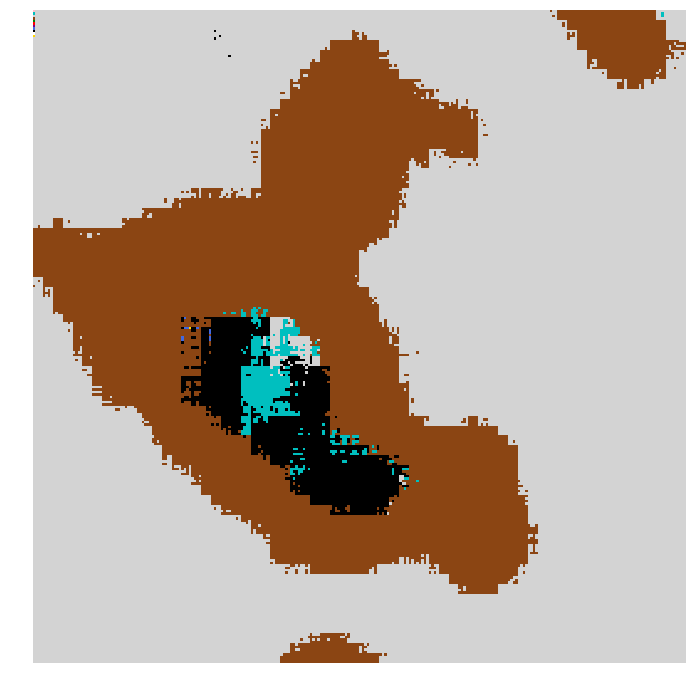

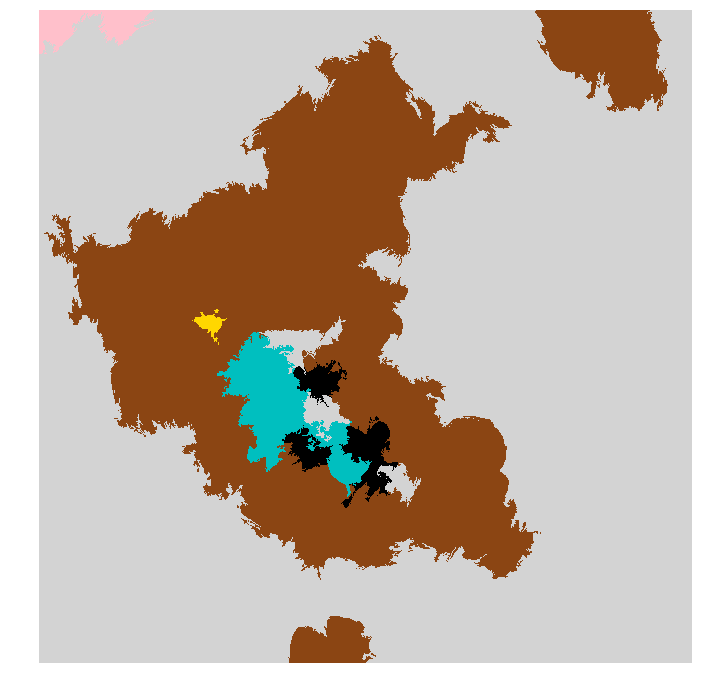

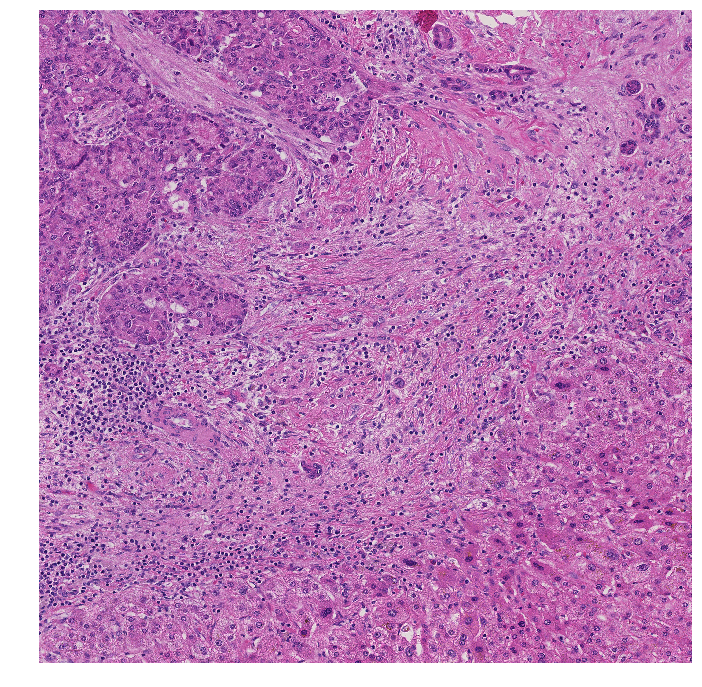

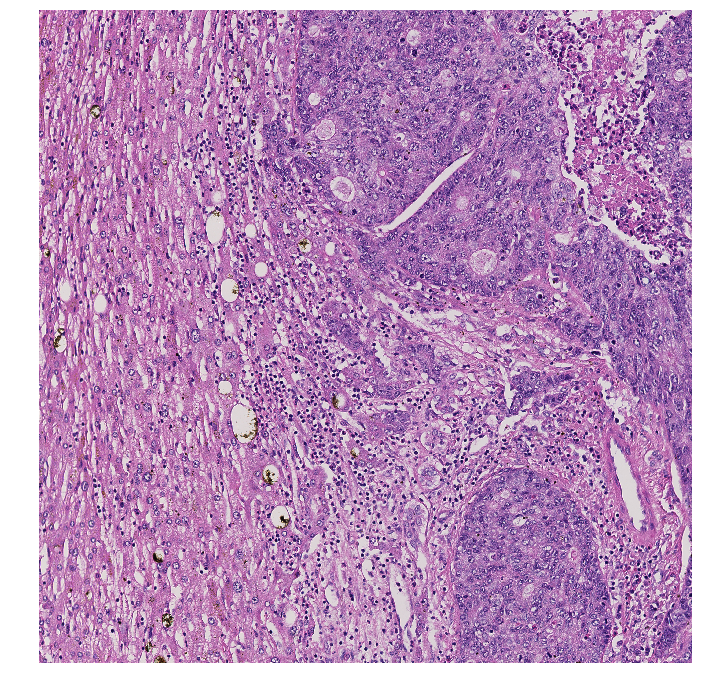

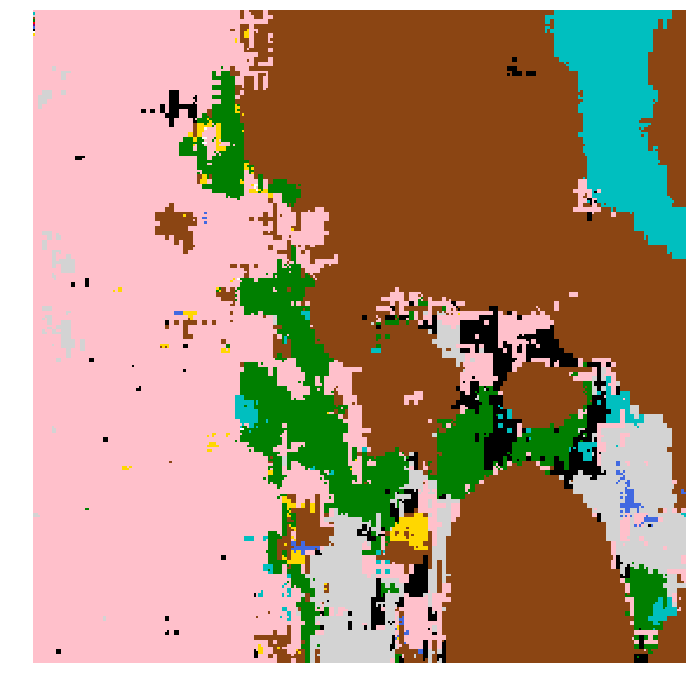

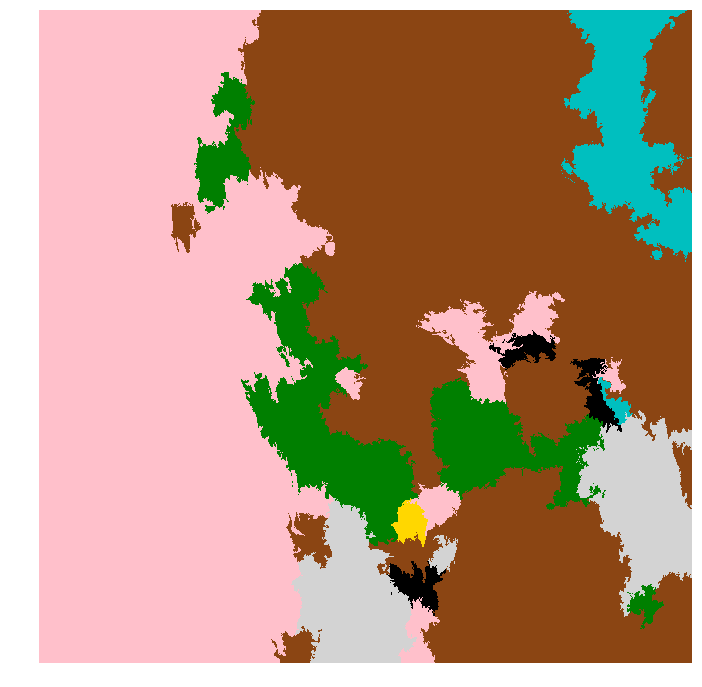

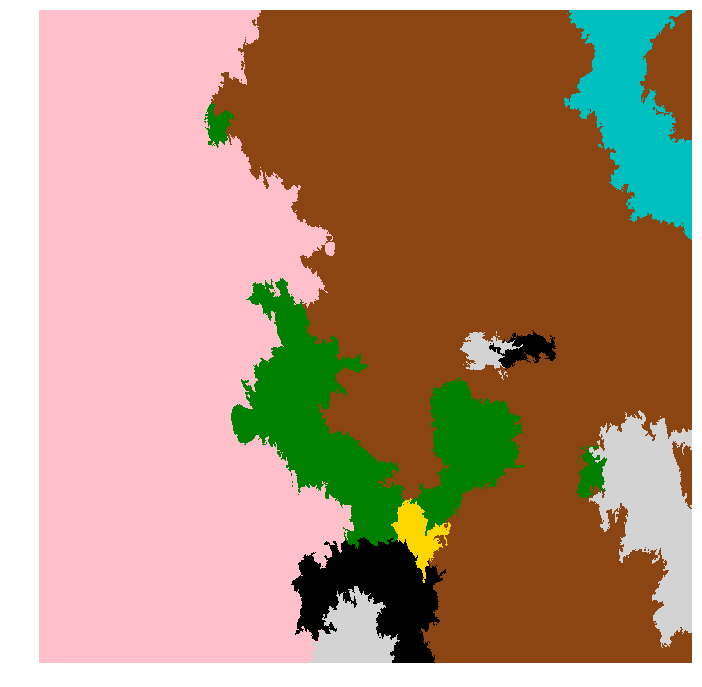

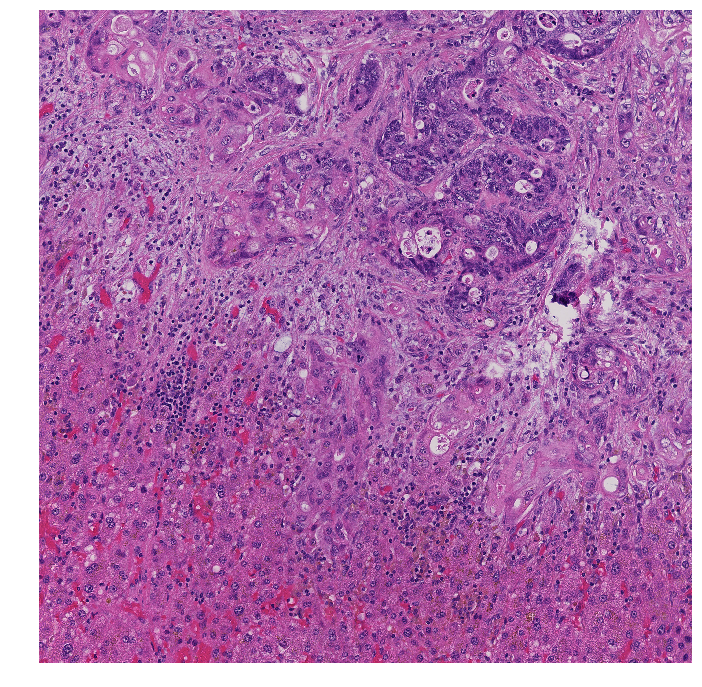

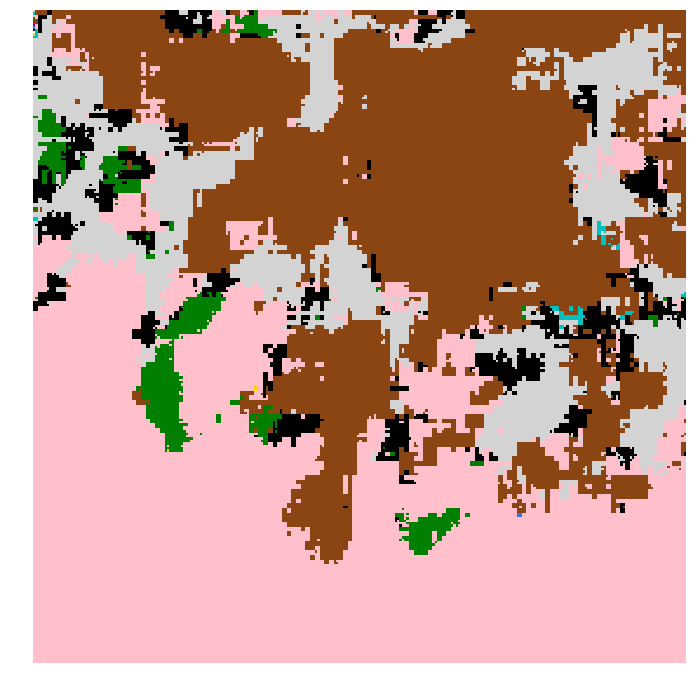

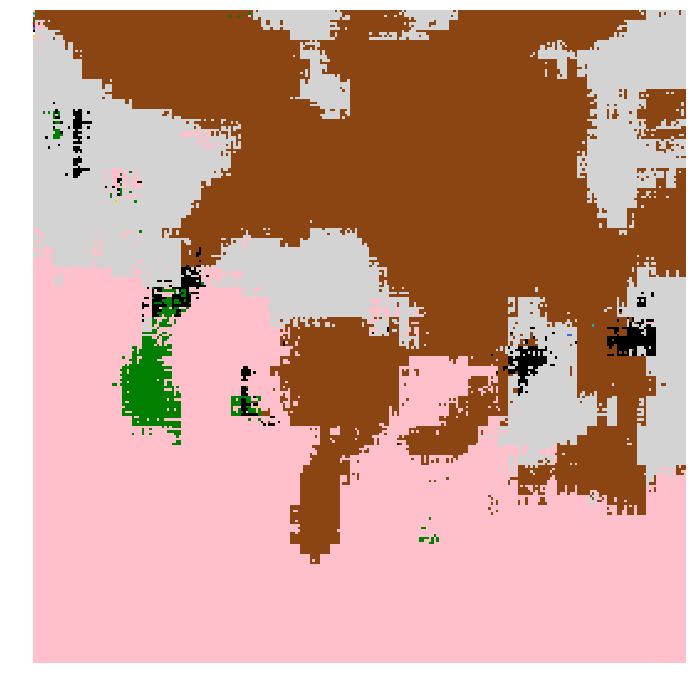

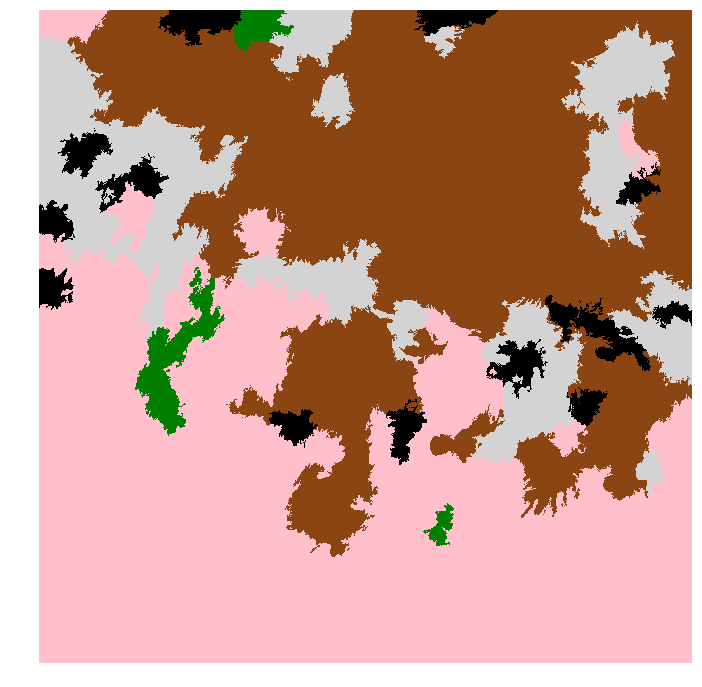

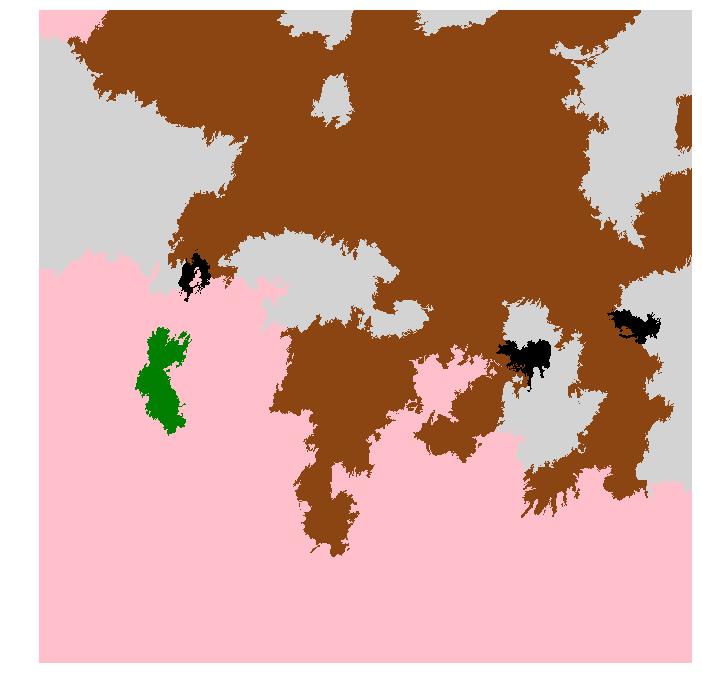

In [71]:
for findex in range(1,5):
    input_patch = plt.imread(eval_path+flist[findex])

    model_448.eval()
    model_448.cuda()
    test_out_448 = process_large_image(model_448,input_patch,step = 56,out_scale =4,num_classes= 11,patch_size = 448,show=False,cuda_size=32)

    model_224.eval()
    model_224.cuda()
    test_out_224 = process_large_image(model_224,input_patch,step = 28,out_scale =2,num_classes= 11,patch_size = 224,show=False,cuda_size=64)

    print(test_out_224.shape)
    print(test_out_448.shape)

    maskp_224 = CNN_Superpixels(im=input_patch,label_tissue=test_out_224)
    maskp_448 = CNN_Superpixels(im=input_patch,label_tissue=test_out_448)
    print(maskp_224.shape)
    print(maskp_448.shape)


    fig = plt.figure(figsize=[12,12])
    plt.imshow(input_patch)
    plt.axis('off')
    img = fig2img(fig)
    img.save('/home/zyx31/Desktop/'+flist[findex][:-4]+'_org.png')


    pl_array_list = [test_out_224.argmax(2),test_out_448.argmax(2),maskp_224[:,:,0],maskp_448[:,:,0]]
    index_string_list = ['pcnn_224','pcnn_448','maskp_224','maskp_448']

    for pl_array,index_string in zip(pl_array_list,index_string_list):
        fig = plt.figure(figsize=[12,12])
        pl_array = np.array(pl_array,dtype=np.int)
        for i in range(11):
            pl_array[i,0,] =i
        plt.imshow(pl_array,cmap=cMap)
        plt.axis('off')
        img = fig2img(fig)
        img.save('/home/zyx31/Desktop/'+flist[findex][:-4]+'_%s.png'%index_string)

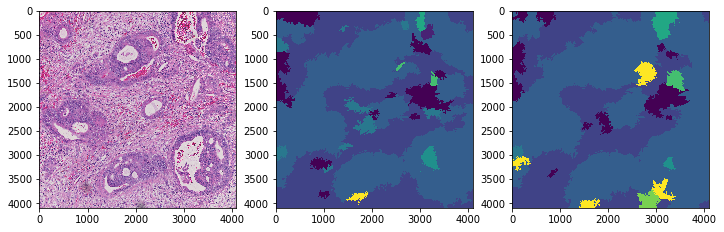

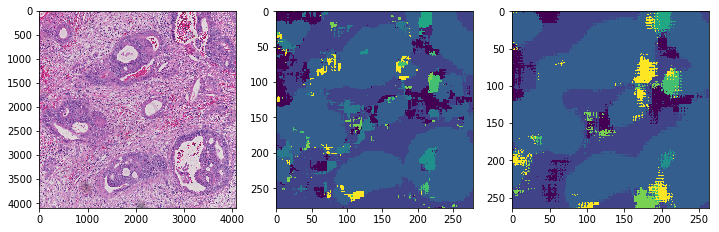

In [54]:
# plt.figure(figsize=[12,12])
# plt.subplot(1,3,1)
# plt.imshow(input_patch)
# plt.subplot(1,3,2)
# plt.imshow(maskp_224[:,:,0])
# plt.subplot(1,3,3)
# plt.imshow(maskp_448[:,:,0])

# plt.figure(figsize=[12,12])
# plt.subplot(1,3,1)
# plt.imshow(input_patch)
# plt.subplot(1,3,2)
# plt.imshow(test_out_224.argmax(2))
# plt.subplot(1,3,3)
# #plt.imshow(maskp[:,:,0])
# plt.imshow(test_out_448.argmax(2))